In [44]:
import modin.pandas as mipd
import os
import time
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [45]:
time_resolution = '1week'

## Technique Network

+ View the Dataset here, read from the saved csv
++ Route('/mnt/data0/lkyin/network_data/emails/')

In [46]:
c_path = './weekly_data/commits/'
projects = os.listdir(c_path)

In [47]:
len(projects)

16460

In [48]:
proj_names = []
for project in tqdm(projects):
    project_name, period = project.replace('.csv', '').split('__')
    proj_names.append(project_name)

pd_proj_names = pd.Series(proj_names)
pd_proj_names.describe()

100%|██████████| 16460/16460 [00:00<00:00, 1109814.71it/s]


count      16460
unique       263
top       tamaya
freq         193
dtype: object

In [49]:
df_commits = pd.read_csv(c_path+projects[0])
df_commits.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'sender_email', 'author_name', 'author_email',
       'file_name', 'loc', 'ref_or_sha', 'subject', 'commit_type',
       'author_full_name', 'is_bot', 'is_coding', 'dealised_author_full_name',
       'week'],
      dtype='object')

In [50]:
df_commits.describe()

,month,author_email,loc,ref_or_sha
count,6.0,0.0,6.000000,6.0
mean,7.0,NaN,257.166667,651504.0
std,0.0,NaN,373.519701,0.0
min,7.0,NaN,58.000000,651504.0
25%,7.0,NaN,68.750000,651504.0
50%,7.0,NaN,106.000000,651504.0
75%,7.0,NaN,180.000000,651504.0
max,7.0,NaN,1012.000000,651504.0


In [51]:
df_commits.head(5)

,project_name,list_name,date,month,message_id,sender_name,sender_email,author_name,author_email,file_name,loc,ref_or_sha,subject,commit_type,author_full_name,is_bot,is_coding,dealised_author_full_name,week
0,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/src/main/...,202.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,carsten ziegeler,False,True,Carsten Ziegeler,2008-04-22/2008-04-28
1,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/src/main/...,114.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,carsten ziegeler,False,True,Carsten Ziegeler,2008-04-22/2008-04-28
2,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/src/main/...,58.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,carsten ziegeler,False,True,Carsten Ziegeler,2008-04-22/2008-04-28
3,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/src/main/...,59.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,carsten ziegeler,False,True,Carsten Ziegeler,2008-04-22/2008-04-28
4,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/src/main/...,1012.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,carsten ziegeler,False,True,Carsten Ziegeler,2008-04-22/2008-04-28


## ASF Techinical Network Construction from Likang
+ Using NetworkX for analysis
    + https://www.osgeo.cn/networkx/tutorial.html#attributes

    + Use Pandas with NetworkX https://www.jianshu.com/p/11456474d8a5

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null (SVN has 'noauthor')
    + For each row:
        + Check if file name exist as node
        + Add file as Node
        + Edges saved in technical_net as a set
        + for each commit on each file, weight +1
    + Use technical_net to construct graph
        + Network attributes from the dictionary: https://www.osgeo.cn/networkx/tutorial.html#attributes

In [52]:
c_path = './weekly_data/commits/'
projects = os.listdir(c_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
to_path = './network_data'+time_resolution+'/commits/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
gx_technets = []
for project in tqdm(projects):
    technical_net = {}
    project_name, period = project.replace('.csv', '').split('__')
    if (int(period))%(int(time_resolution[0]))!=0 :
        continue
    fnames = [project_name+'__'+str(int(period)+i).zfill(3)+'.csv' for i in range(int(time_resolution[0])) ]
    for fname in fnames:
        if not os.path.exists(c_path+fname):
            continue
        df = pd.read_csv(c_path+fname)
        df.query('is_bot == False and is_coding == True', inplace=True)
        df = df[df['dealised_author_full_name'].notna()]
        for index, row in df.iterrows():
            file_path = row['file_name']
            # file extension = '.' + file_path.split('/')[-1].split('.')[-1].split(' ')[0]
            file_name = file_path.split('/')[-1]
            author_name = row['dealised_author_full_name']
            if file_name not in technical_net:
                technical_net[file_name] = {}
            if author_name not in technical_net[file_name]:
                technical_net[file_name][author_name] = {}
                technical_net[file_name][author_name]['weight'] = 0
            technical_net[file_name][author_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(technical_net)
    # add disconnected nodes
    g.add_nodes_from(technical_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_technets.append(g)

100%|██████████| 16460/16460 [06:14<00:00, 43.99it/s] 


In [53]:
int(time_resolution[0])

1

In [54]:
technical_net

{'ManualSetupTest.java': {'Aaron Coburn': {'weight': 1},
  'P Ottlinger': {'weight': 1}},
 ' about.html': {'Hugo Hirsch': {'weight': 1}},
 'index.html': {'Hugo Hirsch': {'weight': 3}},
 ' archive.html': {'Hugo Hirsch': {'weight': 1}},
 'no-jsr-in-javaee8.html': {'Hugo Hirsch': {'weight': 1}},
 'whatistamaya.html': {'Hugo Hirsch': {'weight': 1}},
 'dzone-article.html': {'Hugo Hirsch': {'weight': 1}},
 'introduction.html': {'Hugo Hirsch': {'weight': 1}},
 'javaland.html': {'Hugo Hirsch': {'weight': 3}},
 'new-configuration-api.html': {'Hugo Hirsch': {'weight': 1}},
 'apachecon-seville.html': {'Hugo Hirsch': {'weight': 1}},
 'apachecon-vancouver.html': {'Hugo Hirsch': {'weight': 1}},
 'bedcon.html': {'Hugo Hirsch': {'weight': 1}},
 'dirk-weil-javaeeblog.html': {'Hugo Hirsch': {'weight': 1}},
 'infoq-article.html': {'Hugo Hirsch': {'weight': 1}},
 'java2days-sofia.html': {'Hugo Hirsch': {'weight': 1}},
 'javaone.html': {'Hugo Hirsch': {'weight': 1}},
 'jug-basel.html': {'Hugo Hirsch': {'we

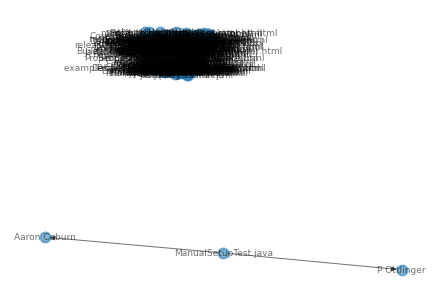

In [55]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)

## ASF Social Networks Construction From Likang

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null
    + For each email:
        + Check if this email have previous references, if not, quit and go next
        + Add previous authors as Nodes
        + Edges saved in social_net as a node
        + for each email sent to previous edges on each file, mutually (sender to previous & previous to sender) weight +1

In [56]:
e_path = './monthly_data/emails/'
projects = os.listdir(e_path)

In [57]:
for project in tqdm(projects[:1]):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    df = pd.read_csv(e_path+project)
    df.query('is_bot == False', inplace=True)
    df = df[df['dealised_author_full_name'].notna()]

100%|██████████| 1/1 [00:00<00:00, 78.93it/s]


In [58]:
df.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'references', 'sender_email', 'in_reply_to', 'cc_list',
       'receiver_email', 'subject', 'body', 'from_commit', 'author_full_name',
       'is_bot', 'dealised_author_full_name'],
      dtype='object')

In [59]:
df.describe()

,month
count,62.0
mean,2.0
std,0.0
min,2.0
25%,2.0
50%,2.0
75%,2.0
max,2.0


In [60]:
df.head(5)

,project_name,list_name,date,month,message_id,sender_name,references,sender_email,in_reply_to,cc_list,receiver_email,subject,body,from_commit,author_full_name,is_bot,dealised_author_full_name
0,taverna,dev,2014-12-01 01:11:07,2.0,<CAPRnXtmtwnMV_x38qy8MOtCCCgW2dLBZ05yPxQUty7Hk...,Stian Soiland-Reyes,<CACnO1SHVo5aBWxe1DdXWkgKcFE2c1K0_Lv=UtGv=c9+t...,soiland-reyes@cs.manchester.ac.uk,<CACnO1SHnGxKcWNn380k2pCpn5zq=nBQPUsyYHVmk5Umx...,None,Nebojsa Tijanic <nebojsa.tijanic@sbgenomics.co...,Re: Workflow model,(dev@taverna - you might see that I occasional...,False,stian soilandreyes,False,Stian Soiland-reyes
1,taverna,dev,2014-12-01 09:38:25,2.0,<547C3711.5030702@apache.org>,Andy Seaborne,<5471BEAB.2070406@apache.org> <5473422B.300080...,andy@apache.org,<CAPRnXtkA2FhS_tuZA61P+kKxSE_paS9EkBvpeEpkwZ3Q...,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,Report signed off by me.\nIf the other mentors...,False,andy seaborne,False,Andy Seaborne
2,taverna,dev,2014-12-01 09:09:28,2.0,<547C7698.2040606@iu.edu>,Marlon Pierce,<5471BEAB.2070406@apache.org> <5473422B.300080...,marpierc@iu.edu,<547C3711.5030702@apache.org>,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,I'll sign off but I don't have edit privileges...,False,marlon pierce,False,Marlon Pierce
3,taverna,dev,2014-12-01 14:14:46,2.0,<BB3E9C4E-5430-4F8A-AD60-090776A41A00@16degree...,Gavin McDonald,<5471BEAB.2070406@apache.org> <5473422B.300080...,gavin@16degrees.com.au,<547C7698.2040606@iu.edu>,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,"\nOn 01/12/2014, at 2:09 PM, Marlon Pierce <ma...",False,gavin mcdonald,False,Gavin Mcdonald
4,taverna,dev,2014-12-01 09:16:36,2.0,<547C7844.3020000@iu.edu>,Marlon Pierce,<5471BEAB.2070406@apache.org> <5473422B.300080...,marpierc@iu.edu,<BB3E9C4E-5430-4F8A-AD60-090776A41A00@16degree...,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,"I have. I'm MarlonPierce.\n\nOn 12/1/14, 9:14 ...",False,marlon pierce,False,Marlon Pierce


In [61]:
to_path = './network_data'+time_resolution+'/emails/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
e_path = './weekly_data/emails/'
projects = os.listdir(e_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
gx_socialnets = []
for project in tqdm(projects):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    if int(period)%int(time_resolution[0])!=0 :
        continue
    fnames = [project_name+'__'+str(int(period)+i).zfill(3)+'.csv' for i in range(int(time_resolution[0])) ]
    for fname in fnames:
        if not os.path.exists(e_path+fname):
            continue
        df = pd.read_csv(e_path+fname)
        df.query('is_bot == False', inplace=True)
        df = df[df['dealised_author_full_name'].notna()]
        
        for index, row in df.iterrows():
            message_id = row['message_id'].strip()
            # print(row['dealised_author_full_name'])
            sender_name = row['dealised_author_full_name']
            emailID_to_author[message_id] = sender_name

        # raise KeyError
        for index, row in df.iterrows():
            message_id = row['message_id']
            references = row['references']
            sender_name = row['dealised_author_full_name']

            # ignores if this email does not to previous emails
            if pd.isna(references) or references == 'None':
                continue

            references = [r.strip() for r in references.replace('\n', ' ').replace('\t', ' ').split(' ') if r.strip()]

            # deal with the issue that a line breaker exists in message_id:
            # e.g., <4\n829AB62.6000302@apache.org>
            new_refs = set()
            for i in range(len(references)-1):
                if '<' in references[i] and '>' not in references[i] and '<' not in references[i+1] and '>' in references[i+1]:
                    new_refs.add(references[i] + references[i+1])
            for r in references:
                if '<' in r and '>' in r:
                    new_refs.add(r)

            references = new_refs
            for reference_id in references:
                if reference_id not in emailID_to_author:
                    continue
                prev_author = emailID_to_author[reference_id]
                # if it's the same person, continue
                if prev_author == sender_name:
                    continue
                if sender_name not in social_net:
                    social_net[sender_name] = {}
                if prev_author not in social_net:
                    social_net[prev_author] = {}

                # if node B replies node A, it means B sends signal to A
                if prev_author not in social_net[sender_name]:
                    social_net[sender_name][prev_author] = {}
                    social_net[sender_name][prev_author]['weight'] = 0
                social_net[sender_name][prev_author]['weight'] += 1

                # if node B replies node A, it means A also sent signal to B
                if sender_name not in social_net[prev_author]:
                    social_net[prev_author][sender_name] = {}
                    social_net[prev_author][sender_name]['weight'] = 0
                social_net[prev_author][sender_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(social_net)
    # add disconnected nodes
    g.add_nodes_from(social_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_socialnets.append(g)

100%|██████████| 24039/24039 [03:59<00:00, 100.33it/s]


In [62]:
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
projects

['atlas__001.csv',
 'kafka__001.csv',
 'jackrabbit__001.csv',
 'juneau__001.csv',
 's2graph__001.csv',
 'sentry__001.csv',
 'libcloud__001.csv',
 'druid__001.csv',
 'provisionr__001.csv',
 'shardingsphere__001.csv',
 'flex__001.csv',
 'felix__001.csv',
 'flume__001.csv',
 'click__001.csv',
 'lenya__001.csv',
 'knox__001.csv',
 'cotton__001.csv',
 'olio__001.csv',
 'spark__001.csv',
 'hise__001.csv',
 'ofbiz__001.csv',
 'datafu__001.csv',
 'ode__001.csv',
 'subversion__001.csv',
 'oodt__001.csv',
 'pulsar__001.csv',
 'openmeetings__001.csv',
 'falcon__001.csv',
 'tashi__001.csv',
 'lens__001.csv',
 'helix__001.csv',
 'cassandra__001.csv',
 'etch__001.csv',
 'shiro__001.csv',
 'storm__001.csv',
 'oozie__001.csv',
 'ranger__001.csv',
 'depot__001.csv',
 'johnzon__001.csv',
 'jclouds__001.csv',
 'dolphinscheduler__001.csv',
 'streams__001.csv',
 'tika__001.csv',
 'superset__001.csv',
 'empire__001.csv',
 'daffodil__001.csv',
 'vxquery__001.csv',
 'concerted__001.csv',
 'stdcxx__001.csv',
 

In [63]:
social_net

{'Upayavira': {'John W Hiltenbrand': {'weight': 1},
  'Zachary Yaro': {'weight': 1}},
 'John W Hiltenbrand': {'Upayavira': {'weight': 1},
  'Zachary Yaro': {'weight': 1}},
 'Zachary Yaro': {'Upayavira': {'weight': 1},
  'John W Hiltenbrand': {'weight': 1}}}

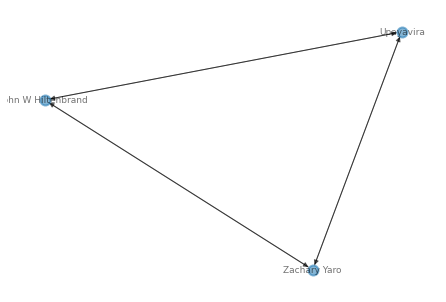

In [64]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)